# Train MLP for MNIST Dataset!!!

In [1]:
from tensorflow import keras # for mnist dataset
import torch #[for torch.tensor(...) {instead of numpy}]
g = torch.Generator().manual_seed(42)
import matplotlib.pyplot as plt

## Get Dataset

In [2]:
(X_train, y_train), (X_VAL, y_val) = keras.datasets.mnist.load_data()
X_train = X_train.reshape((-1, 28*28))/255.
X_val = X_VAL.reshape((-1, 28*28))/255.

X_train = torch.tensor(X_train.tolist())
y_train = torch.tensor(y_train.tolist())
X_val = torch.tensor(X_val.tolist())
y_val = torch.tensor(y_val.tolist())

num_classes = torch.unique(y_train)

print(f"X_train.shape = {X_train.shape}\ny_train.shape = {y_train.shape}\nX_val.shape = {X_val.shape}\ny_val.shape = {y_val.shape}")
del keras

11490434/11490434 [==============================] - 1s 0us/step
X_train.shape = torch.Size([60000, 784])
y_train.shape = torch.Size([60000])
X_val.shape = torch.Size([10000, 784])
y_val.shape = torch.Size([10000])


## MLP-TODO:
* Initialize parameters
* Make minibatches
* Define Activation functions and Loss function
* Forward Pass
* Backward Pass: Compute grads
* Update parameters using gradient descent
* `for` loop for epochs

### Initialize parameters

In [3]:
def initialize_params(size):
    """returns `parmas` (parameters)"""
    # input layer
    w1 = torch.randn((size[0], size[1]), generator=g)*(2./size[0])**0.5
    b1 = torch.randn(size[1], generator=g)*0.01

    # hidden layer 1
    w2 = torch.randn((size[1], size[2]), generator=g)*(2./size[1])**0.5
    b2 = torch.randn(size[2], generator=g)*0.009

    # output layer
    w3 = torch.randn((size[2], size[3]), generator=g)*(2./size[2])**0.5
    b3 = torch.randn(size[3], generator=g)*0.0109

    params = [w1, b1, w2, b2, w3, b3]
    print("Number of parameters in the network:", sum(p.nelement() for p in params))
    # for p in params:
    #     p.requires_grad = True
    return params

### Make minibatches

In [4]:
def shuffle(X, y): # (m, ...), (m, ...)
    """returns X, y (but shuffled)"""
    idx = torch.randperm(X.shape[0])
    return X[idx], y[idx]

In [5]:
def batch(X, y, batch_size):
    """returns X, y (batched form of inputs X and y)"""
    num_features = X.shape[-1]
    rem_idx = None
    if len(X)%batch_size != 0:
        rem_idx = -(len(X)%batch_size)
    X, y = shuffle(X, y) # (m, 784), (m, 10)
    X, y = X[:rem_idx], y[:rem_idx]
    X, y = X[None].reshape((-1, batch_size, num_features)), y[None].reshape((-1, batch_size))
    return X, y # (m//B, B, 784), (m//B, B, 10)

### Define Activation function and Cross Entropy

In [6]:
def relu(x, mode="forward"):
    if "forward" in mode:
      return x * (x > 0)
    elif "backward" in mode:
      return torch.where(x > 0, 1, 0)
    else:
      assert mode in ["forward", "backward"]

In [7]:
def softmax(logits, axis=-1, mode="forward"):
    if "forward" in mode:
      logits = logits - logits.max(axis, keepdim=True).values # (B, 10)
      exp = logits.exp() # (B, 10)
      exp_sum = exp.sum(axis, keepdim=True) # (B, 1)
      return exp/exp_sum # (B, 10)
    elif "backward" in mode:
      nc = logits.shape[-1]
      probs = softmax(logits) # (B, 10)
      t1 = torch.einsum("ij,ik->ijk", probs, probs) # (B, 10, 10)
      t2 = torch.einsum("ij,jk->ijk", probs, torch.eye(nc, nc)) # (B, 10, 10)
      dProbs_dLogits = t2 - t1
      return dProbs_dLogits # (B, 10, 10)
    else:
      assert mode in ["forward", "backward"]

In [8]:
def CrossEntropy(y_true, y_proba, mode="forward"):
  if "forward" in mode:
    log_probs = y_proba.log() # (B, num_classes)
    L = -log_probs[range(len(y_proba)), y_true].mean() # ()
    return L # ()
  elif "backward" in mode:
    B = len(y_proba)
    dL_dLogProba = torch.zeros_like(y_proba) # (B, num_classes)

    dL_dLogProba[range(B), y_true] = -1/B
    dLogProba_dProba = 1/y_proba # (B, num_classes)
    dL_dProba = dL_dLogProba * dLogProba_dProba
    return dL_dProba # (B, num_classes)
  else:
    assert mode in ["forward", "backward"]

### Forward Propagation

In [9]:
def forwardprop(x, y=None, params=[]): # [784, 512, 128, 10]
    """ returns `loss(x, y)`, `y_proba`, `params`, `activations` """
    w1, b1, w2, b2, w3, b3 = params
    
    z1 = x.float() @ w1 + b1 # (B, 512) <== (B, 784) @ (784, 512) + (512)
    h1 = relu(z1) # (B, 512)

    z2 = h1 @ w2 + b2 # (B, 128) <== (B, 512) @ (512, 128)
    h2 = relu(z2) # (B, 128)

    logits = h2 @ w3 + b3 # (B, 10) <== (B, 128) @ (128, 10)
    y_proba = softmax(logits) # (B, 10)
    loss = CrossEntropy(y, y_proba) # ()

    params = [w1, b1, w2, b2, w3, b3]
    activations = [z1, h1, z2, h2, logits]
    return loss, y_proba, params, activations

### BackPropagation

In [10]:
def backprop(x, y, y_proba, params, activations):
    """ returns `grads` (gradients) """
    [w1, b1, w2, b2, w3, b3] = params
    [z1, h1, z2, h2, logits] = activations

    # 3rd Layer
    #################### logits=z3 ######################
    dL_dproba = CrossEntropy(y, y_proba, mode="backward")[:, None, :] # (B, 1, 10)
    dproba_dlogits = softmax(logits, mode="backward") # (B, 10, 10)
    dL_dlogits = (dL_dproba @ dproba_dlogits)[:, 0, :] # (B, 10) <= (B, 1, 10) ### Bij,Bjk->Bik

    ##################### w3 ############################
    dlogits_dw3 = h2 # (B, 128)
    dL_dw3 = dlogits_dw3.T @ dL_dlogits # (B, 128).T @ (B, 10) ===> (128, 10)

    ##################### b3 ############################
    dlogits_db3 = 1
    dL_db3 = (dL_dlogits * dlogits_db3).sum(0) # (B, 10) * () =sum(0)=> (10)

    ##################### h2 ############################
    dlogits_dh2 = w3 # (128, 10)
    dL_dh2 = dL_dlogits @ dlogits_dh2.T; # (B, 10) @ (128, 10).T ====> (B, 128)

    # 2nd Layer
    ##################### z2 ############################
    dh2_dz2 = relu(z2, mode="backward") # (B, 128)
    dL_dz2 = dL_dh2 * dh2_dz2 # (B, 128) * (B, 128) # element wise multiplication

    ##################### w2 ############################
    dz2_dw2 = h1 # (B, 512)
    dL_dw2 = dz2_dw2.T @ dL_dz2 # (B, 512).T @ (B, 128) ==> (512, 128)

    ##################### b2 ############################
    dz2_db2 = 1
    dL_db2 = (dL_dz2 * dz2_db2).sum(0) # (B, 128) ==> (128)

    ##################### h1 ############################
    dz2_dh1 = w2 # (512, 128)
    dL_dh1 = dL_dz2 @ dz2_dh1.T # (B, 128) @ (512, 128).T ==> (B, 512)

    # 1st layer
    ##################### z1 ############################
    dh1_dz1 = relu(z1, mode="backward") # (B, 512)
    dL_dz1 = dL_dh1 * dh1_dz1 # (B, 512) element wise multiplication

    ##################### w1 ############################
    dz1_dw1 = x.float() # (B, 784)
    dL_dw1 = dz1_dw1.T @ dL_dz1 # (B, 784).T @ (B, 512) ==> (784, 512)

    ##################### b1 ############################
    dz1_db1 = 1
    dL_db1 = (dL_dz1 * dz1_db1).sum(0) # (512)

    grads = [dL_dw1, dL_db1, dL_dw2, dL_db2, dL_dw3, dL_db3] # [w1, b1, w2, b2, w3, b3]
    return grads

### Gradient Descent

In [11]:
def update_params(lr, params, grads):
    """returns updated `params` (parameters)"""
    for i in range(len(params)):
        params[i] = params[i] - lr*grads[i]
    return params

### Train Loop

In [12]:
def get_accuracy(y_true, y_probs) :
    y_pred = torch.argmax(y_probs, axis=-1)
    return (y_true==y_pred).float().sum()/len(y_true)

In [13]:
def train_loop(
        lr, 
        epochs,
        train_ds, 
        val_ds,
        batch_size = 32,
        val_interval = 2
    ):
    # gradients = [] # takes up lot of memory
    X_train, y_train = train_ds
    XB_train, yB_train = batch(X_train, y_train, batch_size); m_B = XB_train.shape[0]
    X_val, y_val = val_ds
    
    # initialize parameters
    params = initialize_params(size=[784, 512, 128, 10])

    # For loop for epochs and steps
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}", end=" | ")
        losses = 0
        XB_train, yB_train = shuffle(XB_train, yB_train)
        for step in range(m_B):
            # Get batch
            X_batch, y_batch = XB_train[step], yB_train[step]
            # Forward pass
            loss, y_proba, params, activations = forwardprop(X_batch, y_batch, params); losses += loss
            # Backward pass
            grads = backprop(X_batch, y_batch, y_proba, params, activations)
            #; gradients.append(grads) takes lot of memory, thought of making gif of grads over the course of training
            # Update params
            params = update_params(lr, params, grads)
            # Compute metrics
            y_pred = torch.argmax(y_proba, axis=-1)
        print(f"Loss: {losses/m_B}", end=" | ")
        print(f"Validation Loss: {forwardprop(X_val, y_val, params)[0]} |" if (epoch%val_interval==0 or epoch==epochs-1) else "")
    
    print(f"Train Accuracy: {get_accuracy(y_train, forwardprop(X_train, y_train, params)[1])} |")
    print(f"Validation Accuracy: {get_accuracy(y_val, forwardprop(X_val, y_val, params)[1])} |")
    return params#, gradients

In [14]:
params = train_loop(0.01, 8, [X_train, y_train], [X_val, y_val])

Number of parameters in the network: 468874
Epoch: 1/8 | Loss: 0.5108588933944702 | Validation Loss: 0.27928465604782104 |
Epoch: 2/8 | Loss: 0.25795453786849976 | 
Epoch: 3/8 | Loss: 0.20788878202438354 | Validation Loss: 0.18645399808883667 |
Epoch: 4/8 | Loss: 0.17503146827220917 | 
Epoch: 5/8 | Loss: 0.15139970183372498 | Validation Loss: 0.14376983046531677 |
Epoch: 6/8 | Loss: 0.13275845348834991 | 
Epoch: 7/8 | Loss: 0.11826958507299423 | Validation Loss: 0.12011058628559113 |
Epoch: 8/8 | Loss: 0.10585204511880875 | Validation Loss: 0.11306755244731903 |
Train Accuracy: 0.9739166498184204 |
Validation Accuracy: 0.9660000205039978 |


## Make Predictions

In [34]:
def predict(img_idx):
    img = torch.tensor(X_VAL[img_idx].tolist()) # (1, 28, 28)
    y_true = y_val[img_idx]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    y_pred = torch.argmax(forwardprop(img.reshape((1, -1)), y_true, params)[1], axis=-1)
    print(f"True Digit: {y_true}")
    print(f"Predicted Digit: {y_pred}")
    plt.show()
    return

True Digit: tensor([0])
Predicted Digit: tensor([0])


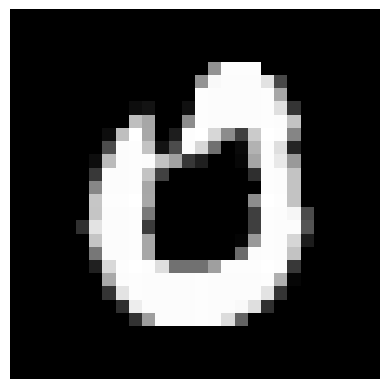

True Digit: tensor([8])
Predicted Digit: tensor([8])


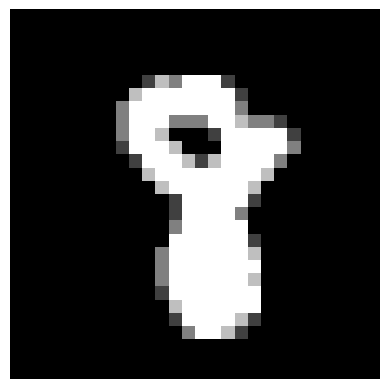

True Digit: tensor([7])
Predicted Digit: tensor([7])


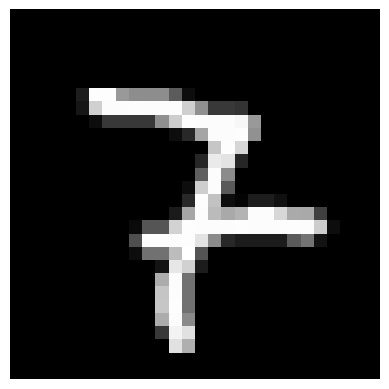

True Digit: tensor([9])
Predicted Digit: tensor([9])


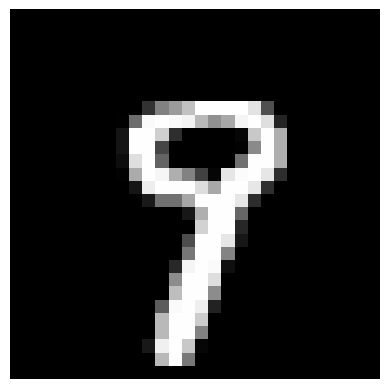

True Digit: tensor([3])
Predicted Digit: tensor([3])


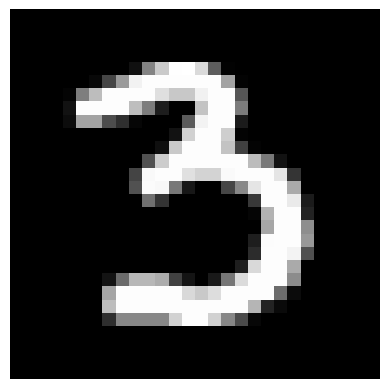

True Digit: tensor([1])
Predicted Digit: tensor([1])


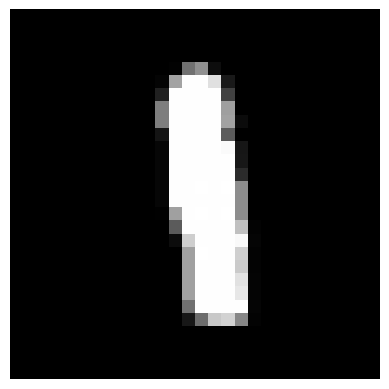

True Digit: tensor([6])
Predicted Digit: tensor([6])


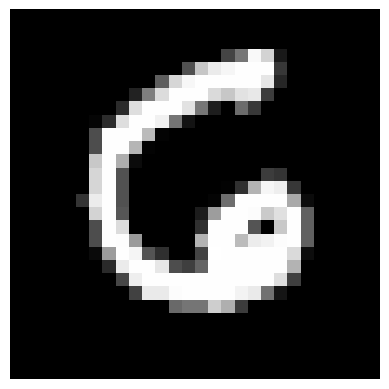

True Digit: tensor([2])
Predicted Digit: tensor([2])


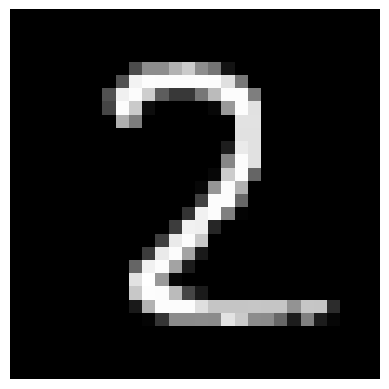

True Digit: tensor([7])
Predicted Digit: tensor([7])


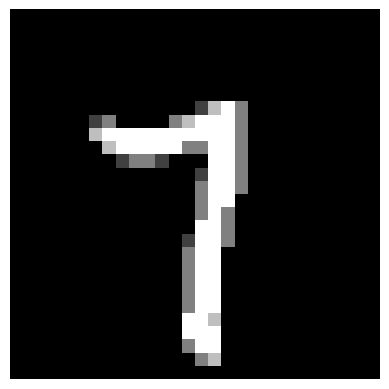

True Digit: tensor([7])
Predicted Digit: tensor([0])


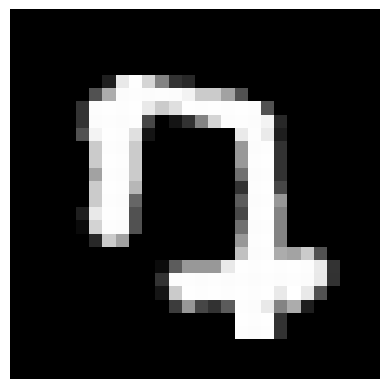

True Digit: tensor([7])
Predicted Digit: tensor([7])


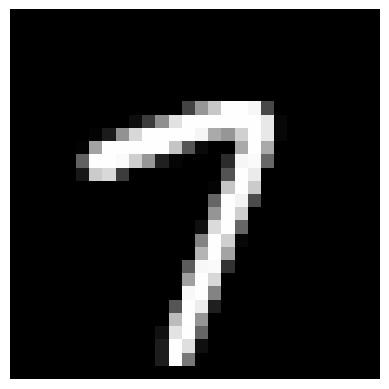

True Digit: tensor([8])
Predicted Digit: tensor([8])


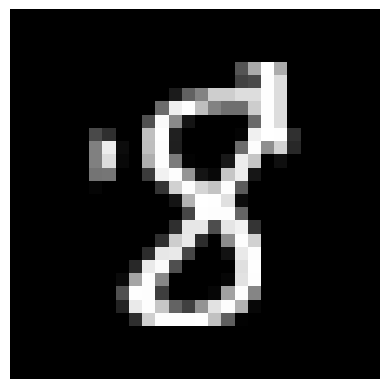

True Digit: tensor([3])
Predicted Digit: tensor([3])


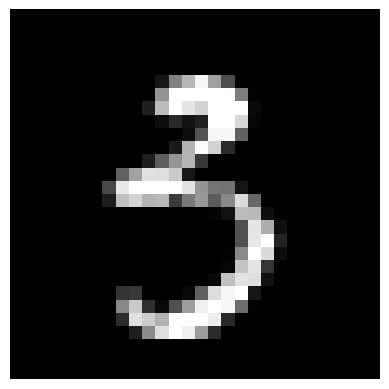

True Digit: tensor([9])
Predicted Digit: tensor([9])


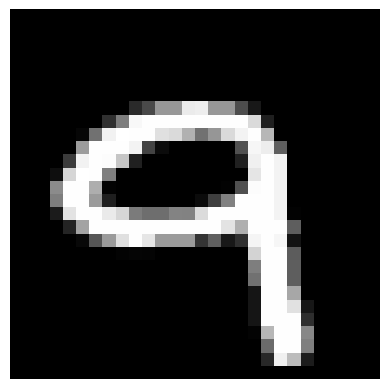

True Digit: tensor([6])
Predicted Digit: tensor([6])


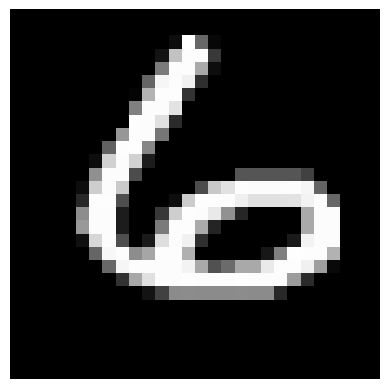

True Digit: tensor([5])
Predicted Digit: tensor([5])


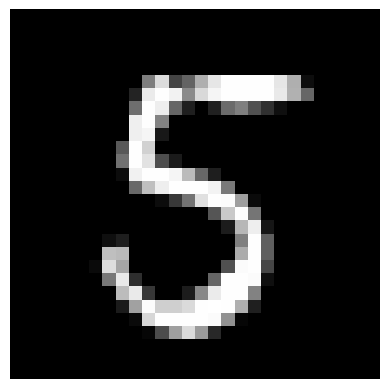

True Digit: tensor([2])
Predicted Digit: tensor([2])


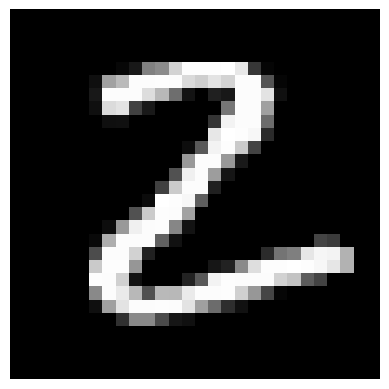

True Digit: tensor([3])
Predicted Digit: tensor([3])


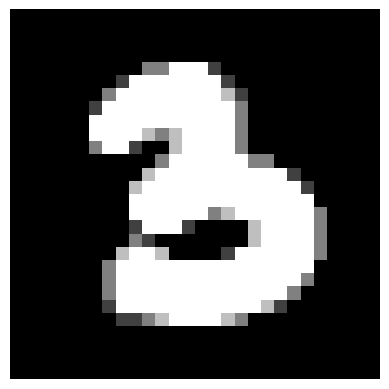

True Digit: tensor([8])
Predicted Digit: tensor([9])


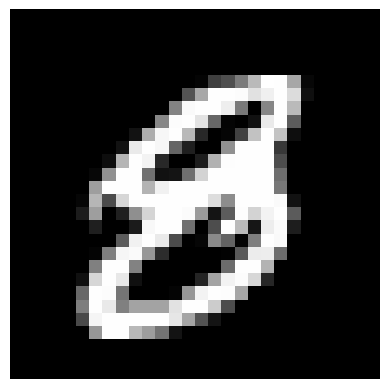

True Digit: tensor([0])
Predicted Digit: tensor([0])


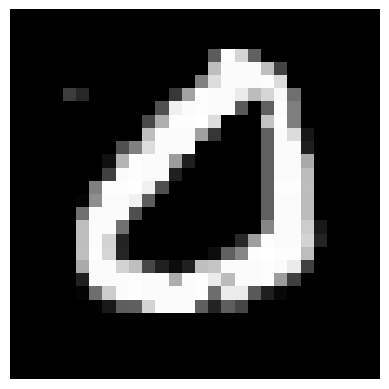

True Digit: tensor([2])
Predicted Digit: tensor([2])


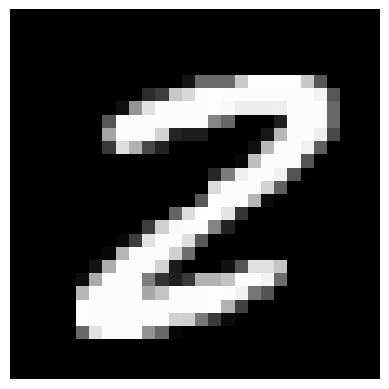

True Digit: tensor([7])
Predicted Digit: tensor([7])


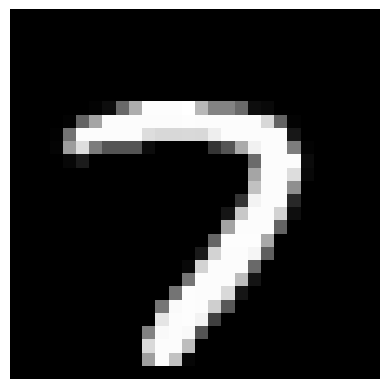

True Digit: tensor([2])
Predicted Digit: tensor([2])


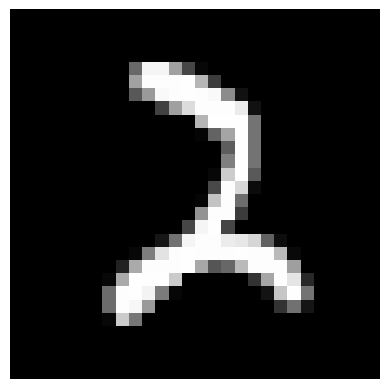

True Digit: tensor([9])
Predicted Digit: tensor([9])


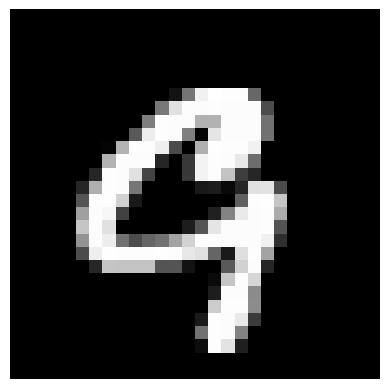

True Digit: tensor([9])
Predicted Digit: tensor([9])


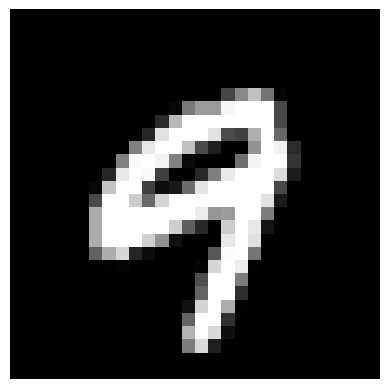

True Digit: tensor([9])
Predicted Digit: tensor([9])


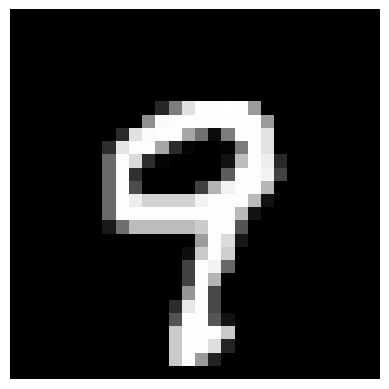

True Digit: tensor([3])
Predicted Digit: tensor([3])


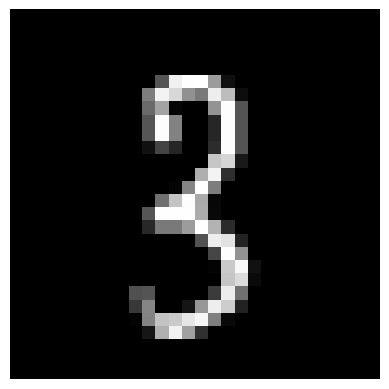

True Digit: tensor([7])
Predicted Digit: tensor([7])


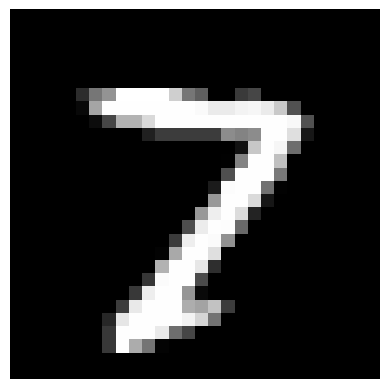

True Digit: tensor([1])
Predicted Digit: tensor([1])


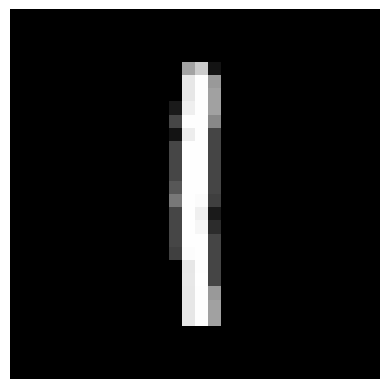

True Digit: tensor([2])
Predicted Digit: tensor([2])


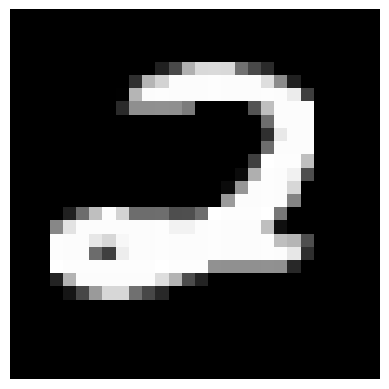

True Digit: tensor([1])
Predicted Digit: tensor([1])


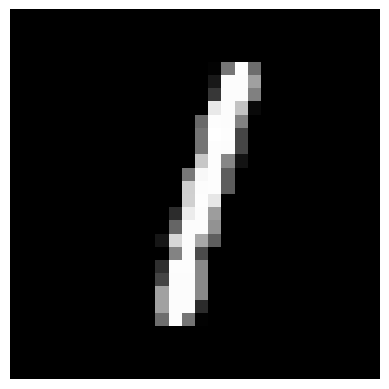

True Digit: tensor([1])
Predicted Digit: tensor([1])


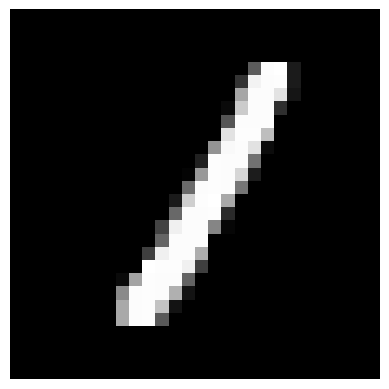

True Digit: tensor([7])
Predicted Digit: tensor([7])


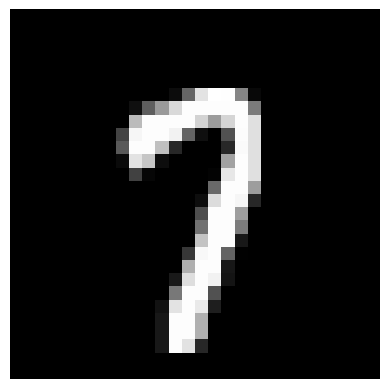

True Digit: tensor([2])
Predicted Digit: tensor([2])


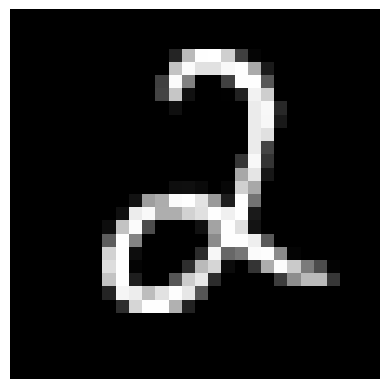

True Digit: tensor([4])
Predicted Digit: tensor([4])


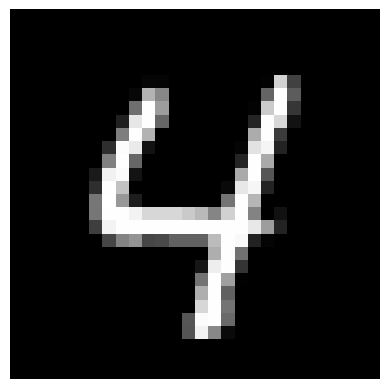

True Digit: tensor([0])
Predicted Digit: tensor([0])


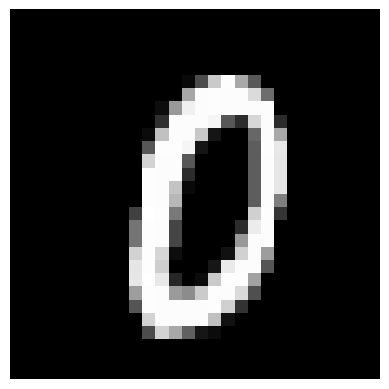

True Digit: tensor([3])
Predicted Digit: tensor([3])


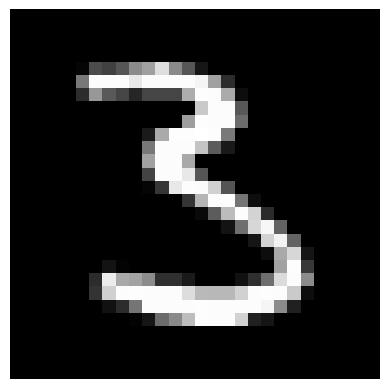

True Digit: tensor([8])
Predicted Digit: tensor([8])


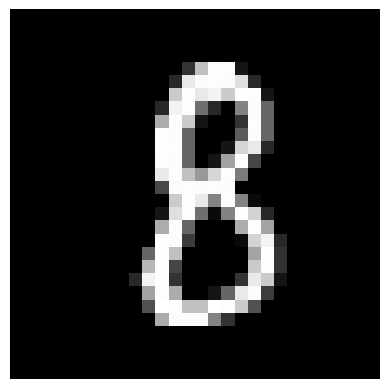

True Digit: tensor([1])
Predicted Digit: tensor([1])


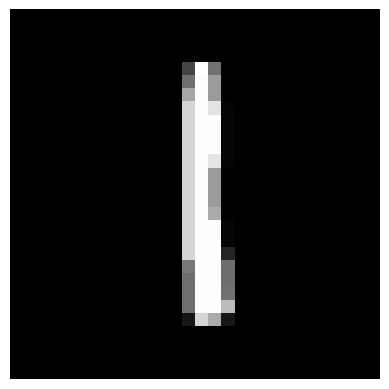

True Digit: tensor([5])
Predicted Digit: tensor([5])


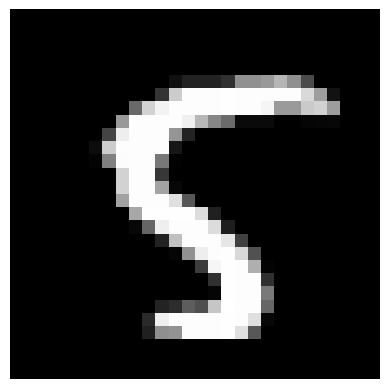

True Digit: tensor([8])
Predicted Digit: tensor([8])


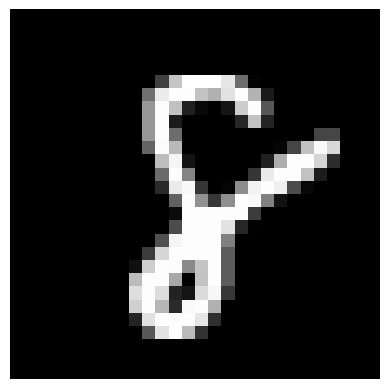

True Digit: tensor([1])
Predicted Digit: tensor([1])


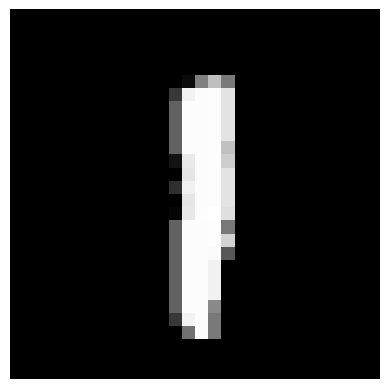

True Digit: tensor([7])
Predicted Digit: tensor([7])


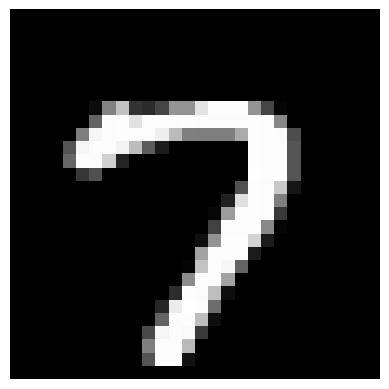

True Digit: tensor([9])
Predicted Digit: tensor([9])


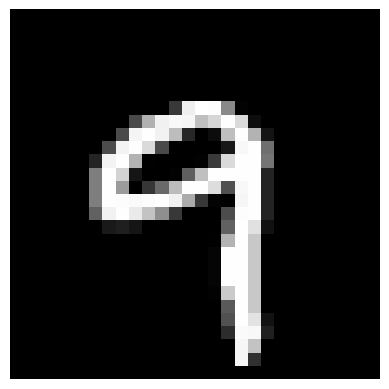

True Digit: tensor([7])
Predicted Digit: tensor([7])


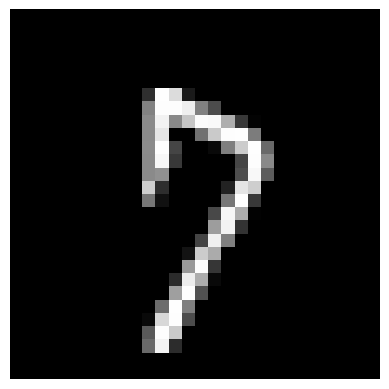

True Digit: tensor([7])
Predicted Digit: tensor([7])


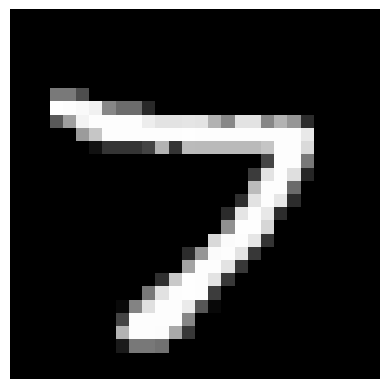

True Digit: tensor([8])
Predicted Digit: tensor([8])


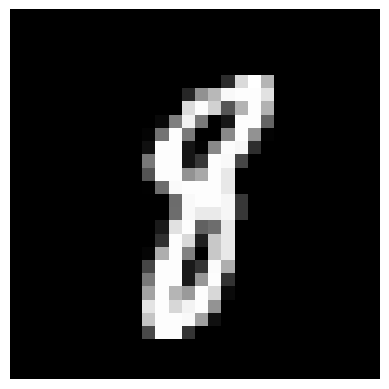

True Digit: tensor([4])
Predicted Digit: tensor([4])


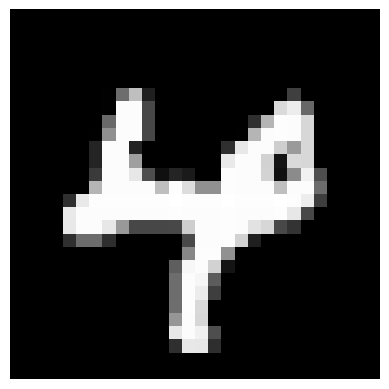

True Digit: tensor([5])
Predicted Digit: tensor([5])


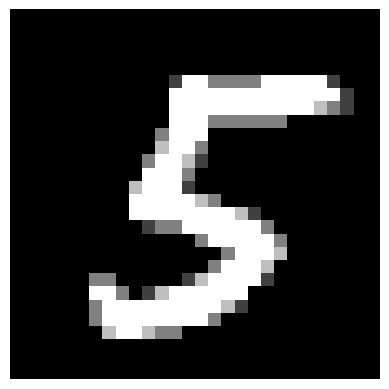

True Digit: tensor([4])
Predicted Digit: tensor([4])


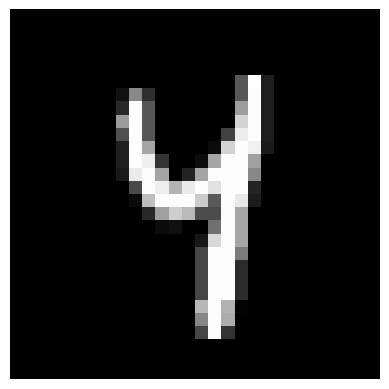

True Digit: tensor([6])
Predicted Digit: tensor([6])


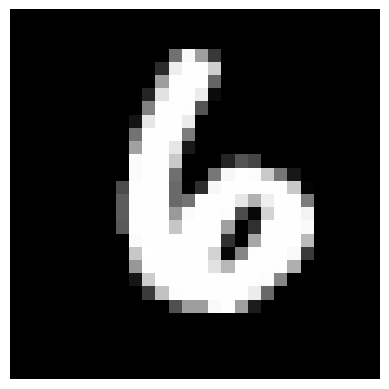

True Digit: tensor([9])
Predicted Digit: tensor([9])


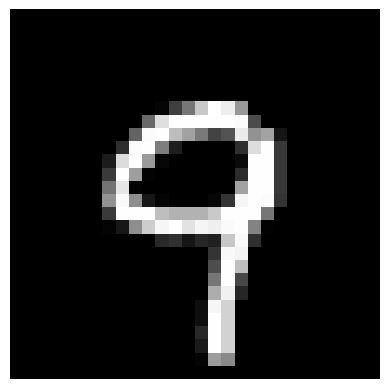

True Digit: tensor([4])
Predicted Digit: tensor([4])


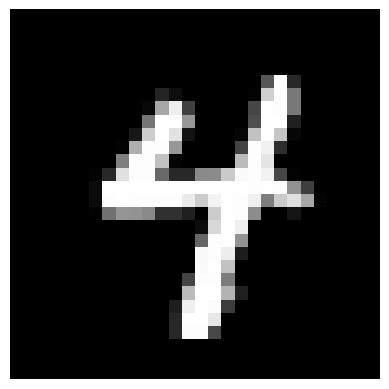

True Digit: tensor([9])
Predicted Digit: tensor([9])


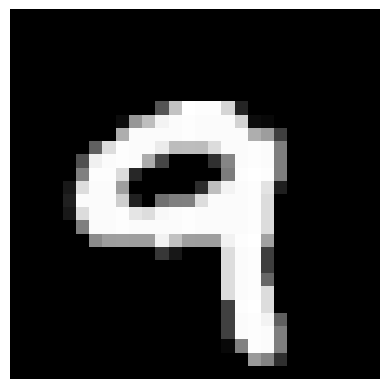

True Digit: tensor([5])
Predicted Digit: tensor([5])


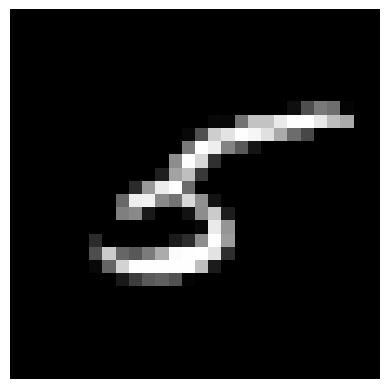

True Digit: tensor([3])
Predicted Digit: tensor([3])


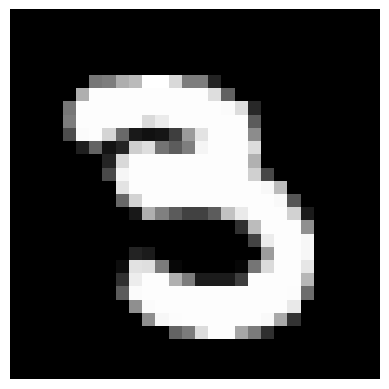

True Digit: tensor([2])
Predicted Digit: tensor([2])


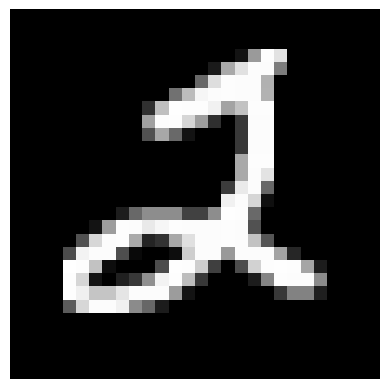

True Digit: tensor([9])
Predicted Digit: tensor([9])


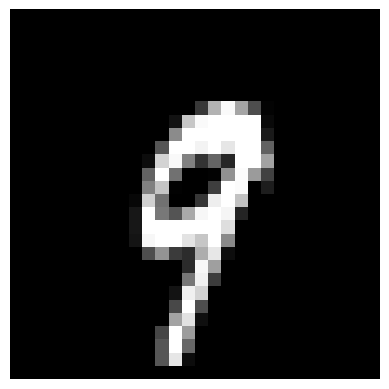

True Digit: tensor([1])
Predicted Digit: tensor([1])


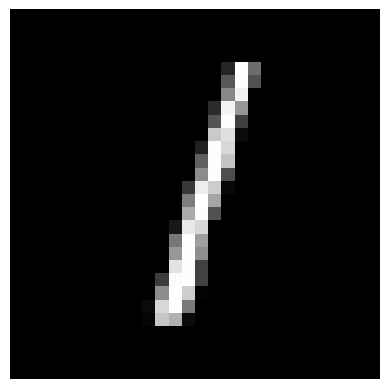

True Digit: tensor([1])
Predicted Digit: tensor([1])


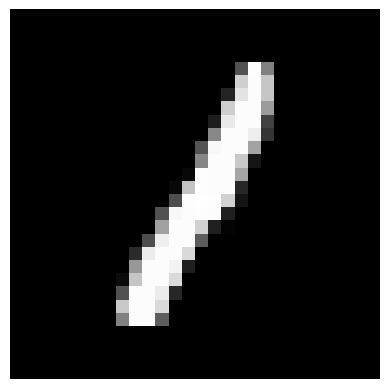

True Digit: tensor([0])
Predicted Digit: tensor([0])


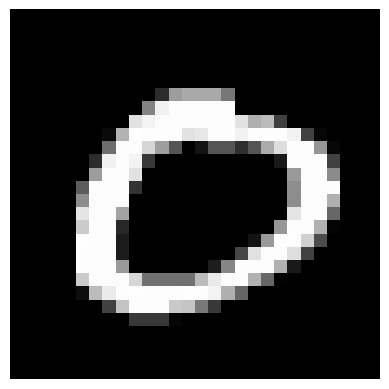

True Digit: tensor([9])
Predicted Digit: tensor([9])


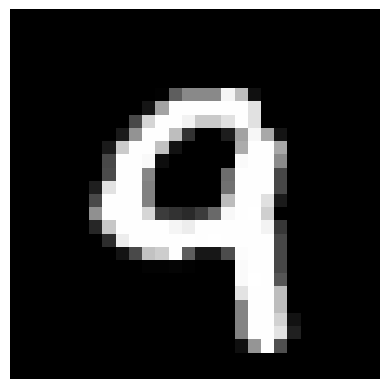

True Digit: tensor([4])
Predicted Digit: tensor([4])


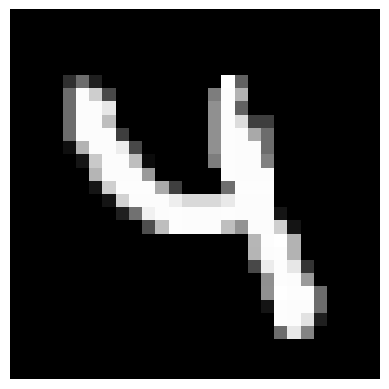

True Digit: tensor([7])
Predicted Digit: tensor([7])


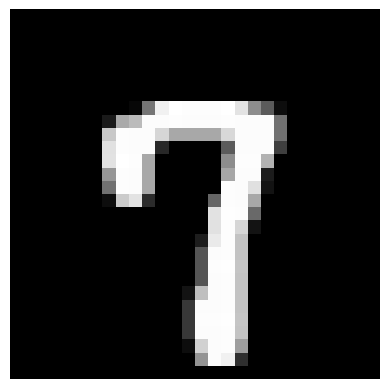

True Digit: tensor([5])
Predicted Digit: tensor([5])


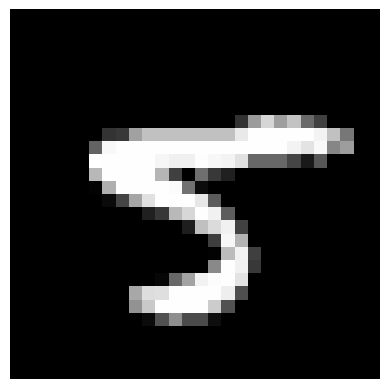

True Digit: tensor([4])
Predicted Digit: tensor([4])


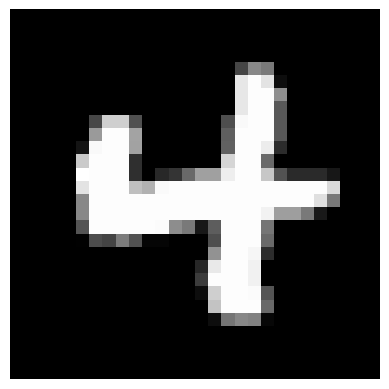

True Digit: tensor([3])
Predicted Digit: tensor([3])


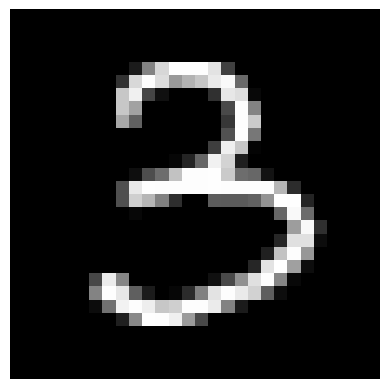

True Digit: tensor([6])
Predicted Digit: tensor([6])


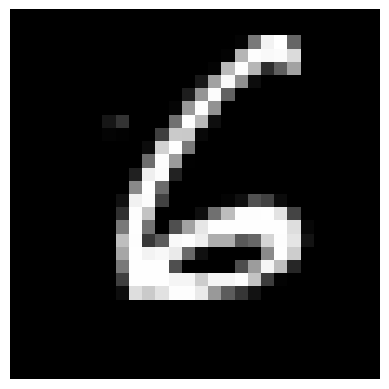

True Digit: tensor([9])
Predicted Digit: tensor([9])


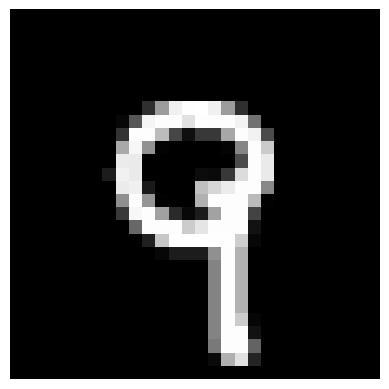

True Digit: tensor([7])
Predicted Digit: tensor([7])


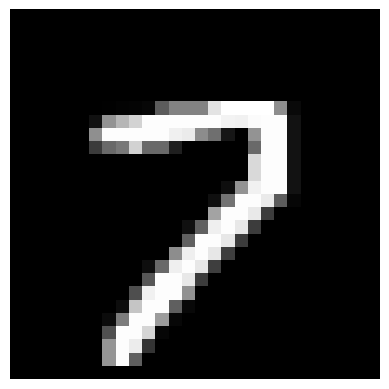

True Digit: tensor([4])
Predicted Digit: tensor([4])


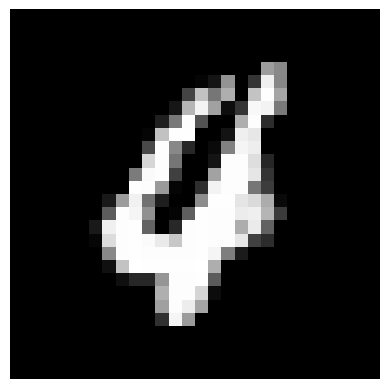

True Digit: tensor([8])
Predicted Digit: tensor([8])


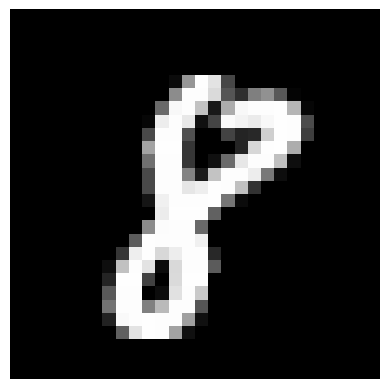

True Digit: tensor([6])
Predicted Digit: tensor([6])


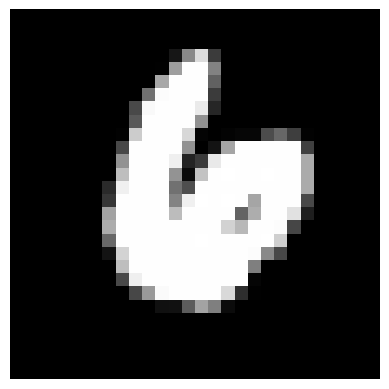

True Digit: tensor([9])
Predicted Digit: tensor([9])


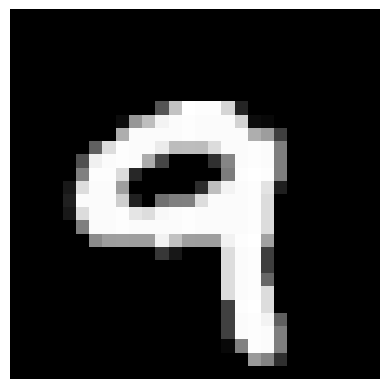

True Digit: tensor([7])
Predicted Digit: tensor([7])


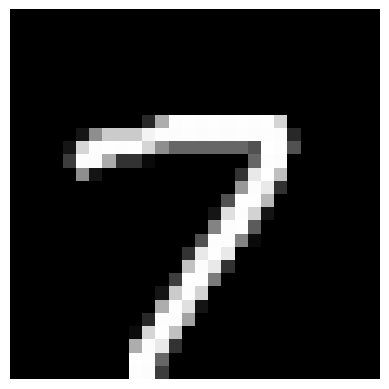

True Digit: tensor([3])
Predicted Digit: tensor([3])


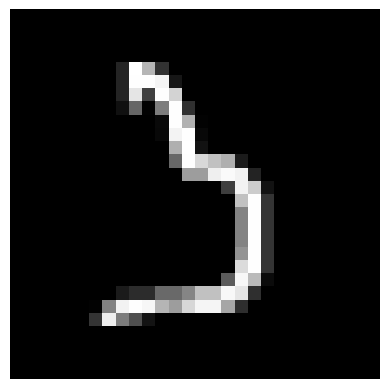

True Digit: tensor([6])
Predicted Digit: tensor([6])


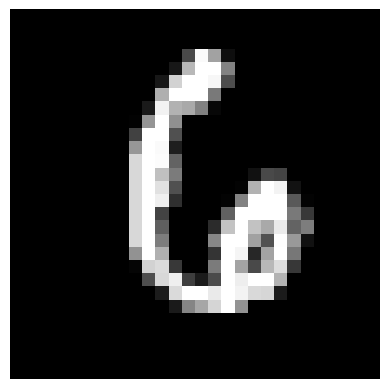

True Digit: tensor([8])
Predicted Digit: tensor([8])


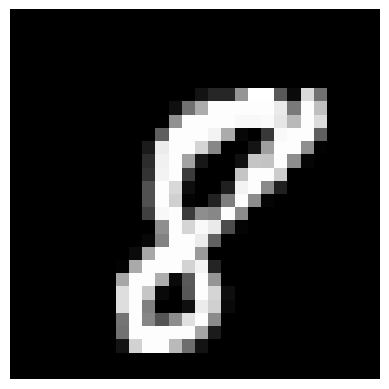

True Digit: tensor([2])
Predicted Digit: tensor([2])


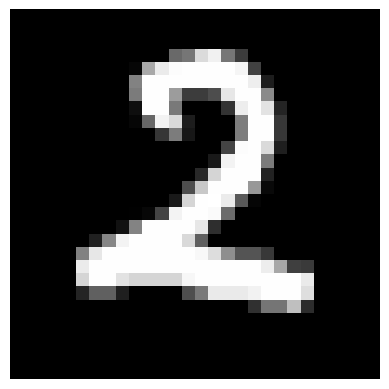

True Digit: tensor([9])
Predicted Digit: tensor([9])


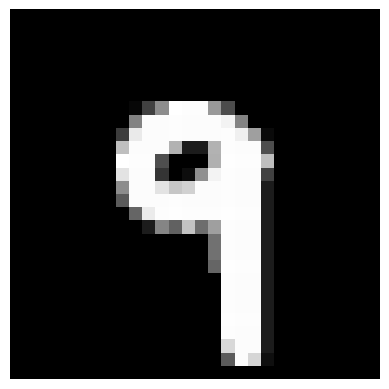

True Digit: tensor([2])
Predicted Digit: tensor([2])


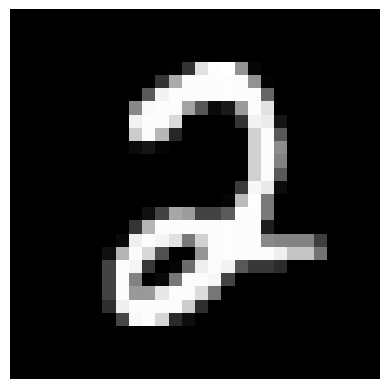

True Digit: tensor([5])
Predicted Digit: tensor([5])


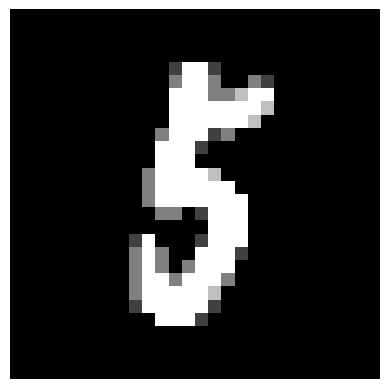

True Digit: tensor([6])
Predicted Digit: tensor([6])


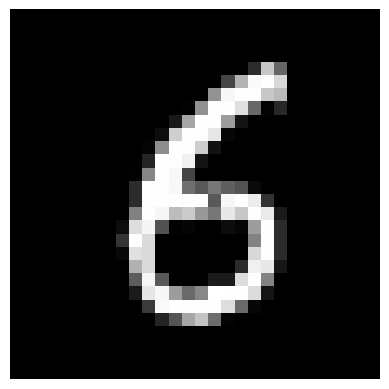

True Digit: tensor([8])
Predicted Digit: tensor([8])


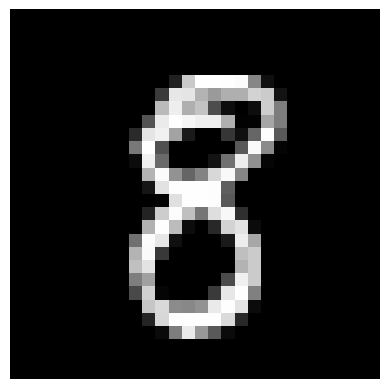

True Digit: tensor([7])
Predicted Digit: tensor([7])


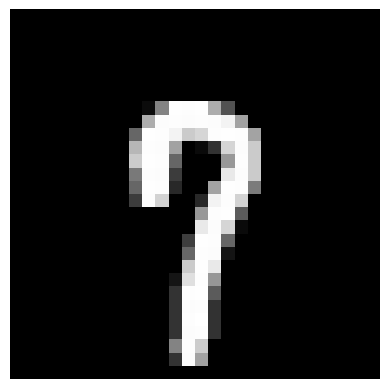

True Digit: tensor([3])
Predicted Digit: tensor([3])


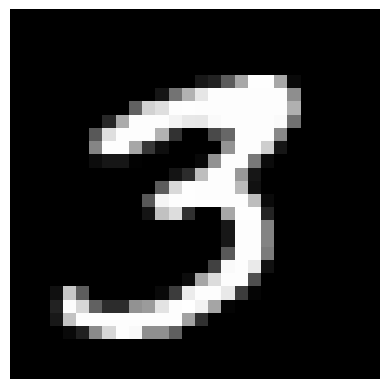

True Digit: tensor([6])
Predicted Digit: tensor([6])


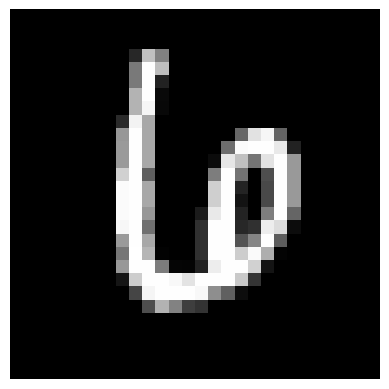

True Digit: tensor([1])
Predicted Digit: tensor([1])


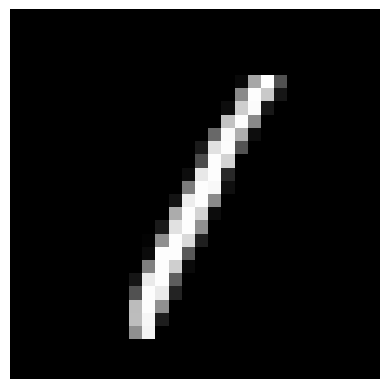

True Digit: tensor([4])
Predicted Digit: tensor([4])


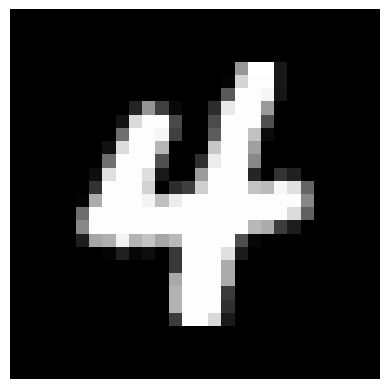

True Digit: tensor([1])
Predicted Digit: tensor([1])


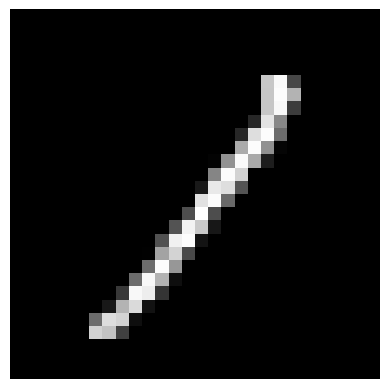

True Digit: tensor([0])
Predicted Digit: tensor([0])


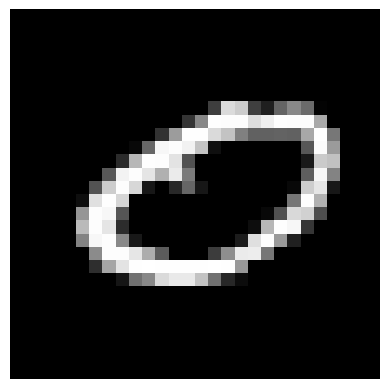

True Digit: tensor([9])
Predicted Digit: tensor([9])


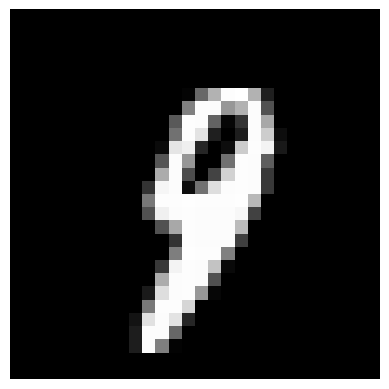

True Digit: tensor([5])
Predicted Digit: tensor([5])


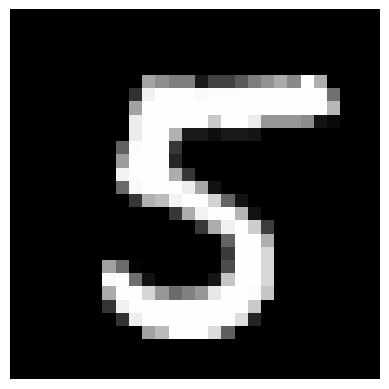

True Digit: tensor([4])
Predicted Digit: tensor([4])


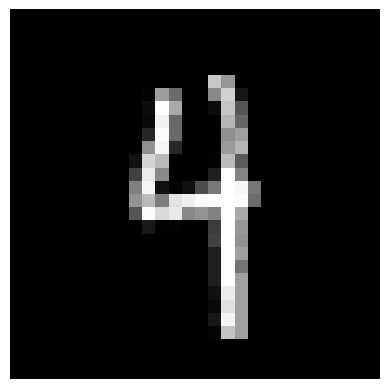

True Digit: tensor([9])
Predicted Digit: tensor([9])


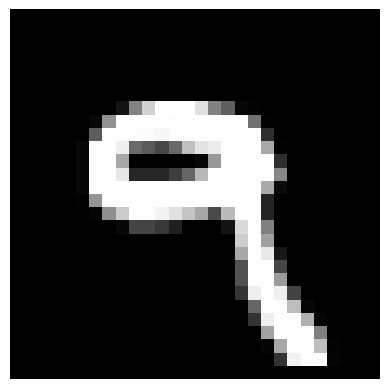

True Digit: tensor([2])
Predicted Digit: tensor([2])


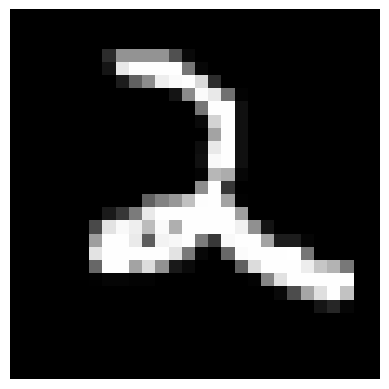

True Digit: tensor([7])
Predicted Digit: tensor([7])


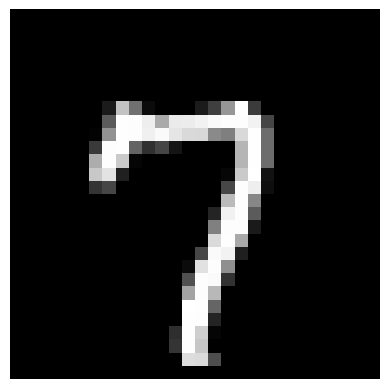

True Digit: tensor([0])
Predicted Digit: tensor([0])


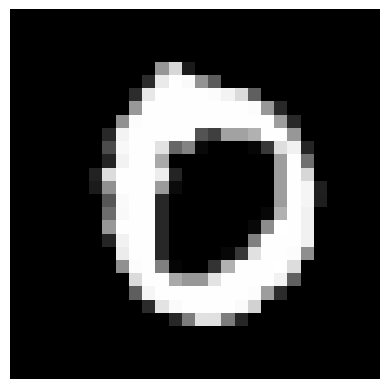

True Digit: tensor([8])
Predicted Digit: tensor([8])


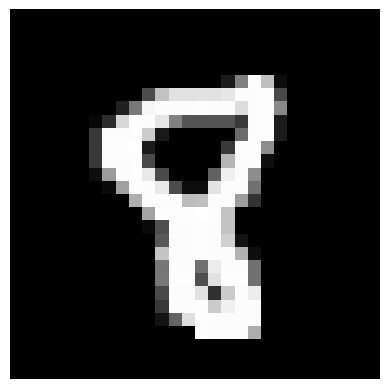

True Digit: tensor([2])
Predicted Digit: tensor([2])


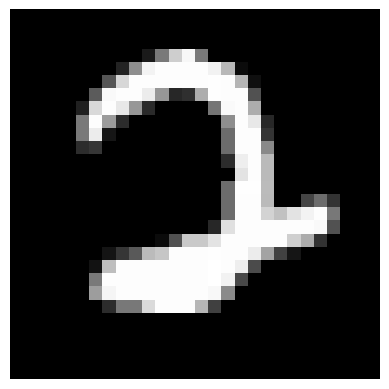

In [35]:
for _ in range(100):
    predict(torch.randint(10_000, (1,)))